In [109]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import glob
from pathlib import Path

from filter.RaymondFilters import RaymondFilter

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from plot_tools import *

# Local import 

from spectra.py_spectra import *

# High Pass values for various values of dx - because of high pass, we want the lowpass filter cutoff to have
# a large (R~0.9) value

npass = 6

dx    = 8

klevel= [25]

filtered_W_name = "W_%2.2i" % dx

print(filtered_W_name)

# Helper functions......

def add_fhour(ds):
    
    filename = ds.encoding["source"].split("_")
    
    init_time = int(filename[-2])
    fhour     = int(filename[-1][-5:-3])
        
    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time
    
    return ds
    

def read_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

def save_mfdataset_list(ds, dir, gridType=None):
    """
    Use xarray.save_mfdataset to save multiple netcdf files from a list, using the original file strings as a pattern
    """

    # Use new pathlib for Python > 3.5
    Path(dir).mkdir(parents=True, exist_ok=True)

    for n, hour in enumerate(hrrr.fhour):
        fcstHour  = ds.isel(fhour=n).fhour.values
        fcstStart = ds.isel(fhour=n).fcstStart
        date      = ds.isel(fhour=n).date      
        
        if gridType == None:
            gridType = ds.isel(fhour=n).attrs['gridType']
            
        outfilename = os.path.join(dir, '%s_%08d%04d_F%02d.nc' % (gridType, date, fcstStart, fcstHour))
        
        ds.isel(fhour=n).to_netcdf(outfilename, mode='w')  
        print(f'Successfully wrote new data to file:: {outfilename}','\n')
    
    return


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
W_08



Plot Lat Min: 34.4  Lat Max:  48.5

Plot Lon Min: -100.5  Lon Max:  -83.7
RaymondFilter6F:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter6F:  NPASS:  6 

NPass Loop for 3D array took 20.7844 seconds


Plot Lat Min: 34.4  Lat Max:  48.5

Plot Lon Min: -100.5  Lon Max:  -83.7
Successfully wrote new data to file:: /Users/Louis.Wicker/CAM_Case_Studies/2020081006/hrrr_W_08/filtered_202008100600_F10.nc 

Successfully wrote new data to file:: /Users/Louis.Wicker/CAM_Case_Studies/2020081006/hrrr_W_08/filtered_202008100600_F11.nc 

Successfully wrote new data to file:: /Users/Louis.Wicker/CAM_Case_Studies/2020081006/hrrr_W_08/filtered_202008100600_F12.nc 

Successfully wrote new data to file:: /Users/Louis.Wicker/CAM_Case_Studies/2020081006/hrrr_W_08/filtered_202008100600_F13.nc 

Successfully wrote new data to file:: /Users/Louis.Wicker/CAM_Case_Studies/2020081006/hrrr_W_08/filtered_202008100600_F14.nc 

Successfully wrote new data to file:: /Users/Louis.W

/Users/Louis.Wicker/miniconda3/envs/mypip/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/Louis.Wicker/miniconda3/envs/mypip/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/Louis.Wicker/miniconda3/envs/mypip/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


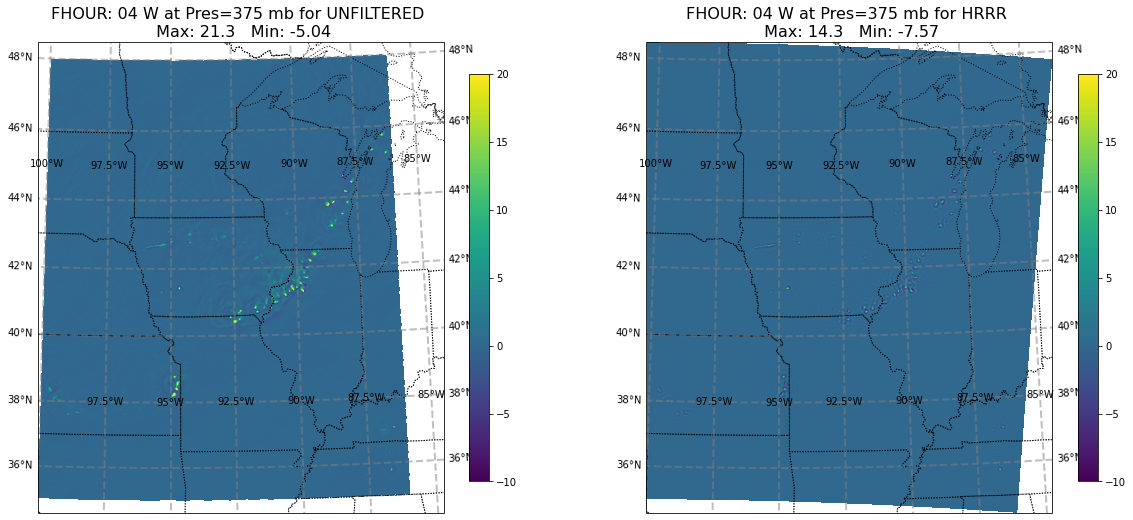

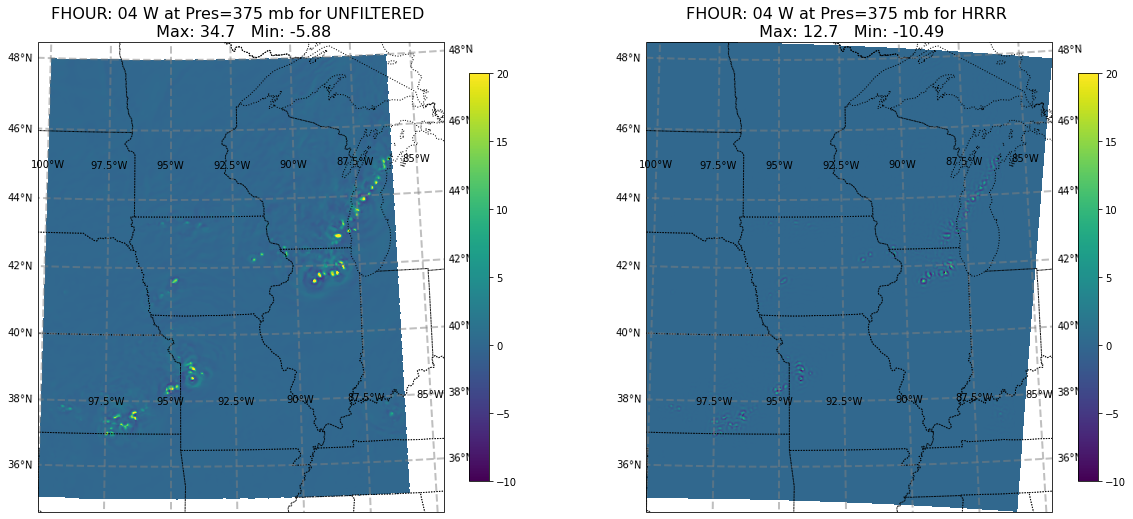

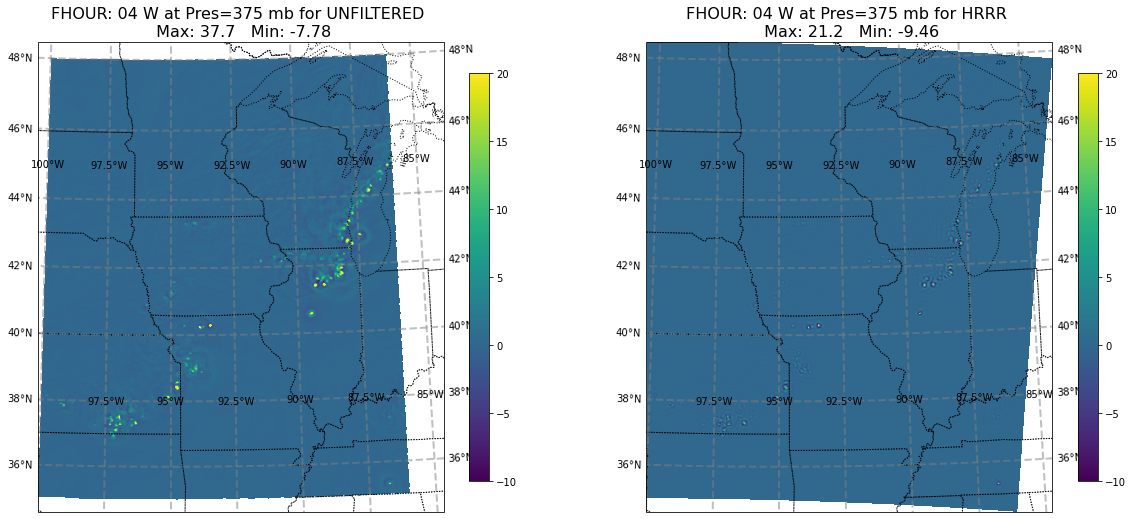

In [115]:
# List data sets

main_dir = "/Users/Louis.Wicker/CAM_Case_Studies"

day      = "2020081006"

#------------------------------------------------------------------------------------
# cut and past from below here
#

hrrr_dir  = str(os.path.join(main_dir, day, "hrrr"))

rrfs0_dir = str(os.path.join(main_dir, day, "ctrl"))
rrfs0_dir = str(os.path.join(main_dir, day, "ctrl"))

rrfs1_dir = str(os.path.join(main_dir, day, "nord3"))

# Open data sets

def filter_ds(dir, suffix):
    
    new_dir = "%s_%s" % (dir, suffix)
    
    ds  = read_mfdataset_list(dir , "region_*.nc")

    # Set up cartopy stuff here, so the plot routine is already set to use it.

    fig, axes = init_cartopy_plot(ncols=2, nrows=1, figsize=(20,10))

    # Plot the initial data

    cb_info = plot_w_from_xarray(ds, klevel=klevel, fhour=4, title='UNFILTERED', ax = axes[0])

    # Convert to numpy arrays, fill in zeros

    w = np.nan_to_num(ds.W.values).astype('float64')

    nhour, nz, ny, nx = w.shape

    w = w.reshape(nhour*nz, ny, nx)

    w_filtered = RaymondFilter(w, dx, order=6, npass = npass, highpass=True)

    ds['W'] = xr.DataArray(w_filtered.reshape(nhour,nz,ny,nx), dims = ['fhour','nz','ny','nx'])

    # Plot the Filtered data

    cb_info = plot_w_from_xarray(ds, klevel=klevel, fhour=4, title='FILTERED', ax = axes[1])

    save_mfdataset_list(ds, new_dir, gridType='filtered')
    
    return

hrrr_dir  = str(os.path.join(main_dir, day, "hrrr"))
filter_ds(hrrr_dir, filtered_W_name)

rrfs0_dir = str(os.path.join(main_dir, day, "ctrl"))
filter_ds(rrfs0_dir, filtered_W_name)

rrfs1_dir = str(os.path.join(main_dir, day, "nord3"))
filter_ds(rrfs1_dir, filtered_W_name)


In [114]:
print(rrfs0)

<xarray.Dataset>
Dimensions:    (fhour: 6, nz: 45, ny: 502, nx: 425)
Coordinates:
    pres       (nz) int64 dask.array<chunksize=(45,), meta=np.ndarray>
    lons       (ny, nx) float32 dask.array<chunksize=(502, 425), meta=np.ndarray>
    lats       (ny, nx) float32 dask.array<chunksize=(502, 425), meta=np.ndarray>
  * fhour      (fhour) int64 10 11 12 13 14 15
    init_time  int64 202008100600
Dimensions without coordinates: nz, ny, nx
Data variables:
    TEMP       (fhour, nz, ny, nx) float32 dask.array<chunksize=(1, 45, 502, 425), meta=np.ndarray>
    HGT        (fhour, ny, nx) float32 dask.array<chunksize=(1, 502, 425), meta=np.ndarray>
    GPH        (fhour, nz, ny, nx) float32 dask.array<chunksize=(1, 45, 502, 425), meta=np.ndarray>
    W          (fhour, nz, ny, nx) float32 dask.array<chunksize=(1, 45, 502, 425), meta=np.ndarray>
    U          (fhour, nz, ny, nx) float32 dask.array<chunksize=(1, 45, 502, 425), meta=np.ndarray>
    V          (fhour, nz, ny, nx) float32 dask.arr

In [101]:
ds = hrrr    
for n, hour in enumerate(hrrr.fhour):
    fcstHour  = ds.isel(fhour=n).fhour.values
    fcstStart = ds.isel(fhour=n).fcstStart
    date      = ds.isel(fhour=n).date
    
    gridType  = ds.isel(fhour=n).attrs['gridType']

    print(os.path.join('test', '%s_%08d%04d_F%02d.nc' % (gridType, date, fcstStart, fcstHour)))

test/region_202008100600_F10.nc
test/region_202008100600_F11.nc
test/region_202008100600_F12.nc
test/region_202008100600_F13.nc
test/region_202008100600_F14.nc
test/region_202008100600_F15.nc



----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30



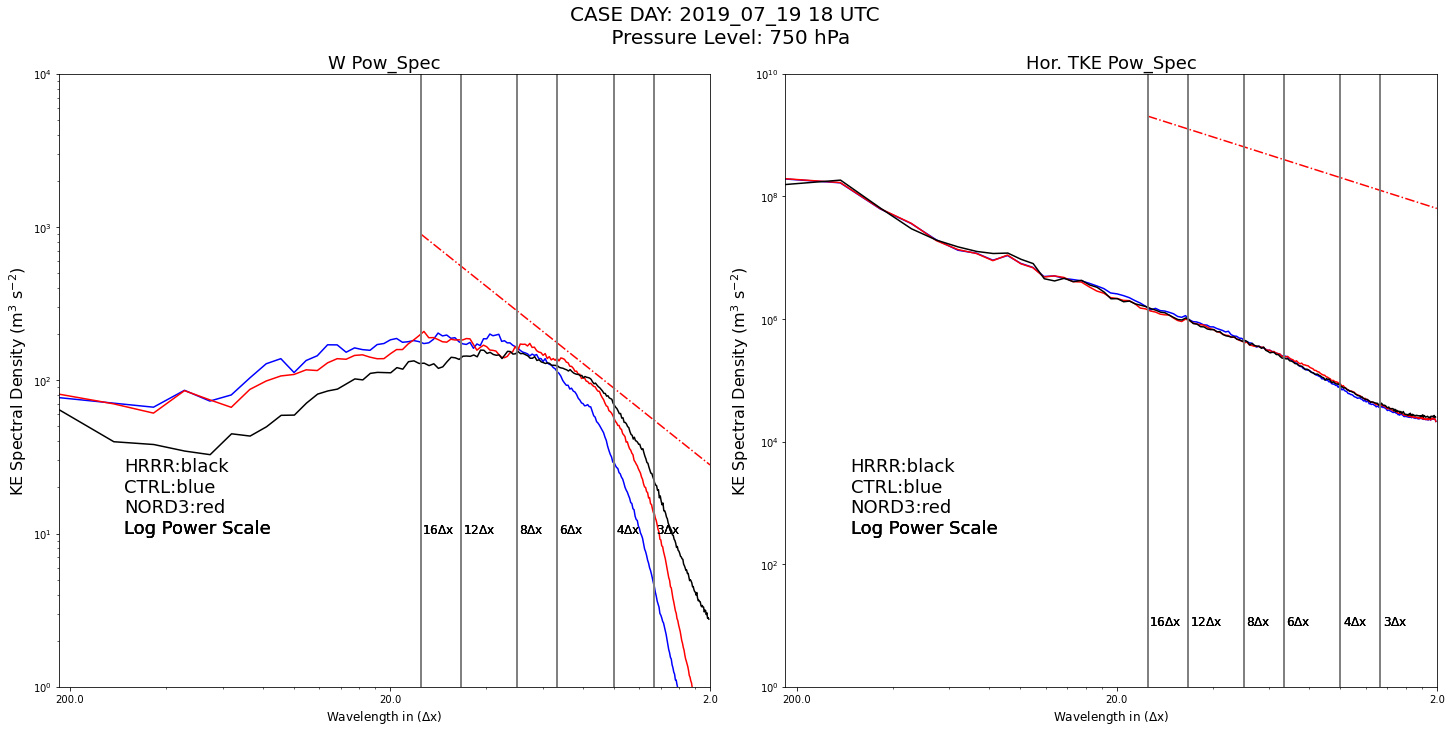


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30



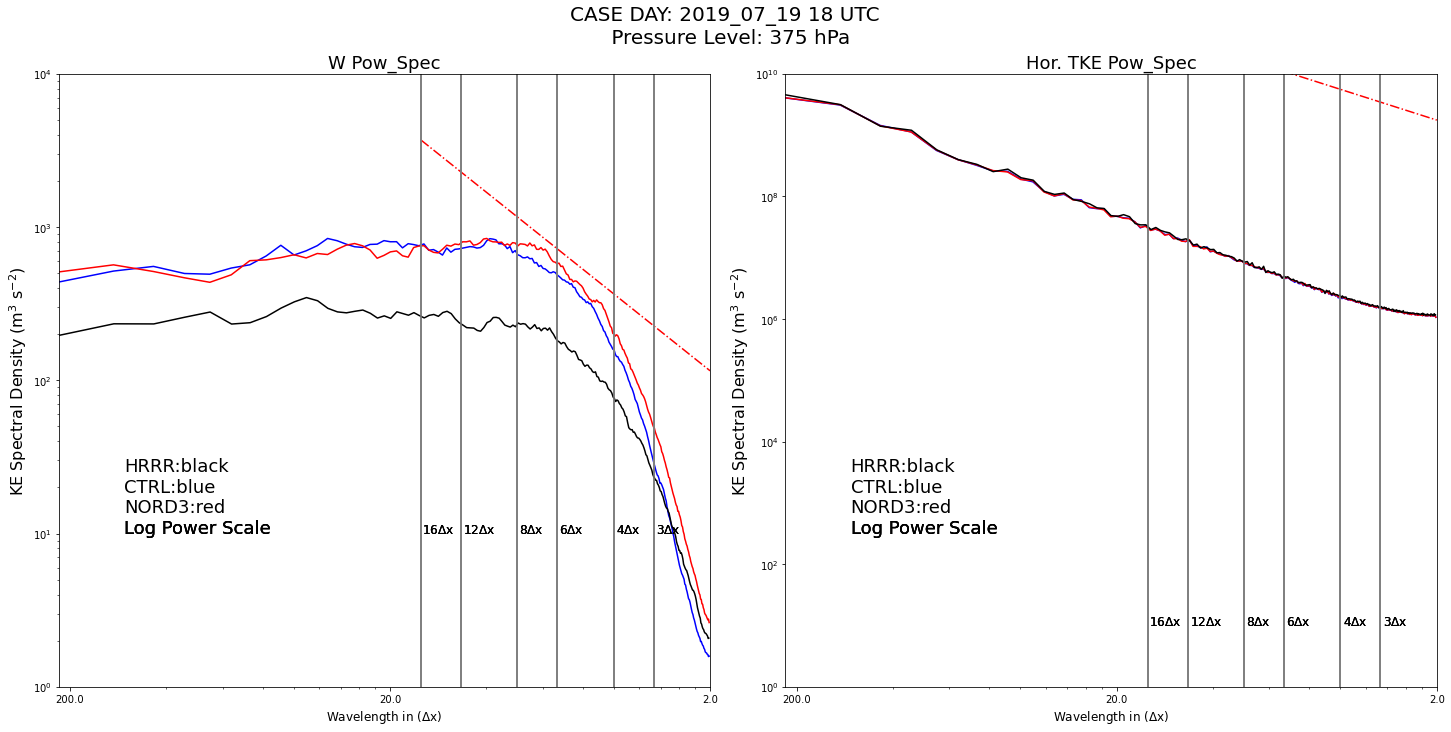

In [ ]:
# List data sets

main_dir = "/Users/Louis.Wicker/CAM_Case_Studies"

day      = "2019071918"

#------------------------------------------------------------------------------------
# cut and past from below here
#

hrrr_dir  = str(os.path.join(main_dir, day, "hrrr"))
rrfs0_dir = str(os.path.join(main_dir, day, "ctrl"))
rrfs1_dir = str(os.path.join(main_dir, day, "nord3"))

# Open data sets

hrrr  = open_mfdataset_list(hrrr_dir , "region_*.nc")
rrfs0 = open_mfdataset_list(rrfs0_dir, "region_*.nc")
rrfs1 = open_mfdataset_list(rrfs1_dir, "region_*.nc")

# Loop over the analy_klevels to create multiple plots

for k in analysis_levels:
    
    # these five levels are averaged together
    
    klevels = [k-2, k-1, k, k+1, k+2]

    # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

    hrrr_u = np.nan_to_num(hrrr.U.isel(nz=klevels).values).astype('float64')
    hrrr_v = np.nan_to_num(hrrr.V.isel(nz=klevels).values).astype('float64')
    hrrr_w = np.nan_to_num(hrrr.W.isel(nz=klevels).values).astype('float64')

    hrrr_tk2 = 0.5*(hrrr_u**2 + hrrr_v**2)


    rrfs0_u = np.nan_to_num(rrfs0.U.isel(nz=klevels).values).astype('float64')
    rrfs0_v = np.nan_to_num(rrfs0.V.isel(nz=klevels).values).astype('float64')
    rrfs0_w = np.nan_to_num(rrfs0.W.isel(nz=klevels).values).astype('float64')

    rrfs0_tk2 = 0.5*(rrfs0_u**2 + rrfs0_v**2)

    rrfs1_u = np.nan_to_num(rrfs1.U.isel(nz=klevels).values).astype('float64')
    rrfs1_v = np.nan_to_num(rrfs1.V.isel(nz=klevels).values).astype('float64')
    rrfs1_w = np.nan_to_num(rrfs1.W.isel(nz=klevels).values).astype('float64')

    rrfs1_tk2 = 0.5*(rrfs1_u**2 + rrfs1_v**2)

    # Compute spectra...

    fig = plt.figure(constrained_layout=True,figsize=(20,10))

    ylim = 1.0e4
    axis = 0
    func = get_spectra2D_POWSPEC

    gs = gridspec.GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])

    plot_spectra(rrfs0_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=[1,ylim], LinsborgSlope=True)
    plot_spectra(rrfs1_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=[1,ylim])
    plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'W Pow_Spec', ylim=[1,ylim])

    ax1 = fig.add_subplot(gs[0, 1])
    ylim = 1.0e10

    plot_spectra(rrfs0_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=[1,ylim], LinsborgSlope=True)
    plot_spectra(rrfs1_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=[1,ylim])
    plot_spectra(hrrr_tk2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'Hor. TKE Pow_Spec', ylim=[1,ylim])

    plt.suptitle("CASE DAY: %s_%s_%s %s UTC \n Pressure Level: %d hPa" % (day[0:4],day[4:6],day[6:8],day[8:10],hrrr.pres[k]/100), fontsize=20)

    plt.savefig("%s/spectra_%3.3d_hPa.pdf" % (os.path.join(main_dir, day), hrrr.pres[k]/100),bbox_inches='tight')

    plt.show()

In [ ]:
# List data sets

main_dir = "/Users/Louis.Wicker/CAM_Case_Studies"

day      = "2021050400"

#------------------------------------------------------------------------------------
# cut and past from below here
#

hrrr_dir  = str(os.path.join(main_dir, day, "hrrr"))
rrfs0_dir = str(os.path.join(main_dir, day, "ctrl"))
rrfs1_dir = str(os.path.join(main_dir, day, "nord3"))

# Open data sets

hrrr  = open_mfdataset_list(hrrr_dir , "region_*.nc")
rrfs0 = open_mfdataset_list(rrfs0_dir, "region_*.nc")
rrfs1 = open_mfdataset_list(rrfs1_dir, "region_*.nc")

# Loop over the analy_klevels to create multiple plots

for k in analy_klevels:
    klevels = [k-2, k-1, k, k+1, k+2]

    # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

    hrrr_u = np.nan_to_num(hrrr.U.isel(nz=klevels).values).astype('float64')
    hrrr_v = np.nan_to_num(hrrr.V.isel(nz=klevels).values).astype('float64')
    hrrr_w = np.nan_to_num(hrrr.W.isel(nz=klevels).values).astype('float64')

    hrrr_tk2 = 0.5*(hrrr_u**2 + hrrr_v**2)


    rrfs0_u = np.nan_to_num(rrfs0.U.isel(nz=klevels).values).astype('float64')
    rrfs0_v = np.nan_to_num(rrfs0.V.isel(nz=klevels).values).astype('float64')
    rrfs0_w = np.nan_to_num(rrfs0.W.isel(nz=klevels).values).astype('float64')

    rrfs0_tk2 = 0.5*(rrfs0_u**2 + rrfs0_v**2)

    rrfs1_u = np.nan_to_num(rrfs1.U.isel(nz=klevels).values).astype('float64')
    rrfs1_v = np.nan_to_num(rrfs1.V.isel(nz=klevels).values).astype('float64')
    rrfs1_w = np.nan_to_num(rrfs1.W.isel(nz=klevels).values).astype('float64')

    rrfs1_tk2 = 0.5*(rrfs1_u**2 + rrfs1_v**2)

    # Compute spectra...

    fig = plt.figure(constrained_layout=True,figsize=(20,10))

    ylim = 1.0e4
    axis = 0
    func = get_spectra2D_POWSPEC

    gs = gridspec.GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])

    plot_spectra(rrfs0_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=[1,ylim], LinsborgSlope=True)
    plot_spectra(rrfs1_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=[1,ylim])
    plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'W Pow_Spec', ylim=[1,ylim])

    ax1 = fig.add_subplot(gs[0, 1])
    ylim = 1.0e10

    plot_spectra(rrfs0_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=[1,ylim], LinsborgSlope=True)
    plot_spectra(rrfs1_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=[1,ylim])
    plot_spectra(hrrr_tk2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'Hor. TKE Pow_Spec', ylim=[1,ylim])

    plt.suptitle("CASE DAY: %s_%s_%s %s UTC \n Pressure Level: %d hPa" % (day[0:4],day[4:6],day[6:8],day[8:10],hrrr.pres[k]/100), fontsize=20)

    plt.savefig("%s/spectra_%3.3d_hPa.pdf" % (os.path.join(main_dir, day), hrrr.pres[k]/100),bbox_inches='tight')

    plt.show()

In [ ]:
# List data sets

main_dir = "/Users/Louis.Wicker/CAM_Case_Studies"

day      = "2020081006"

#------------------------------------------------------------------------------------
# cut and past from below here
#

hrrr_dir  = str(os.path.join(main_dir, day, "hrrr"))
rrfs0_dir = str(os.path.join(main_dir, day, "ctrl"))
rrfs1_dir = str(os.path.join(main_dir, day, "nord3"))

# Open data sets

hrrr  = open_mfdataset_list(hrrr_dir , "region_*.nc")
rrfs0 = open_mfdataset_list(rrfs0_dir, "region_*.nc")
rrfs1 = open_mfdataset_list(rrfs1_dir, "region_*.nc")

# Loop over the analy_klevels to create multiple plots

for k in analy_klevels:
    klevels = [k-2, k-1, k, k+1, k+2]

    # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

    hrrr_u = np.nan_to_num(hrrr.U.isel(nz=klevels).values).astype('float64')
    hrrr_v = np.nan_to_num(hrrr.V.isel(nz=klevels).values).astype('float64')
    hrrr_w = np.nan_to_num(hrrr.W.isel(nz=klevels).values).astype('float64')

    hrrr_tk2 = 0.5*(hrrr_u**2 + hrrr_v**2)


    rrfs0_u = np.nan_to_num(rrfs0.U.isel(nz=klevels).values).astype('float64')
    rrfs0_v = np.nan_to_num(rrfs0.V.isel(nz=klevels).values).astype('float64')
    rrfs0_w = np.nan_to_num(rrfs0.W.isel(nz=klevels).values).astype('float64')

    rrfs0_tk2 = 0.5*(rrfs0_u**2 + rrfs0_v**2)

    rrfs1_u = np.nan_to_num(rrfs1.U.isel(nz=klevels).values).astype('float64')
    rrfs1_v = np.nan_to_num(rrfs1.V.isel(nz=klevels).values).astype('float64')
    rrfs1_w = np.nan_to_num(rrfs1.W.isel(nz=klevels).values).astype('float64')

    rrfs1_tk2 = 0.5*(rrfs1_u**2 + rrfs1_v**2)

    # Compute spectra...

    fig = plt.figure(constrained_layout=True,figsize=(20,10))

    ylim = 1.0e4
    axis = 0
    func = get_spectra2D_POWSPEC

    gs = gridspec.GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])

    plot_spectra(rrfs0_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=[1,ylim], LinsborgSlope=True)
    plot_spectra(rrfs1_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=[1,ylim])
    plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'W Pow_Spec', ylim=[1,ylim])

    ax1 = fig.add_subplot(gs[0, 1])
    ylim = 1.0e10

    plot_spectra(rrfs0_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=[1,ylim], LinsborgSlope=True)
    plot_spectra(rrfs1_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=[1,ylim])
    plot_spectra(hrrr_tk2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'Hor. TKE Pow_Spec', ylim=[1,ylim])

    plt.suptitle("CASE DAY: %s_%s_%s %s UTC \n Pressure Level: %d hPa" % (day[0:4],day[4:6],day[6:8],day[8:10],hrrr.pres[k]/100), fontsize=20)

    plt.savefig("%s/spectra_%3.3d_hPa.pdf" % (os.path.join(main_dir, day), hrrr.pres[k]/100),bbox_inches='tight')

    plt.show()

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from filter.RaymondFilters import RaymondFilter6, RaymondFilter10
from plot_tools import *

# Set up cartopy stuff here, so the plot routine is already set to use it.

fig, axes = init_cartopy_plot(ncols=3, nrows=1, figsize=(30,10))

# Plot the HRRR and RRFS data

cb_info = plot_w_from_xarray(hrrr, klevel=klevel, title='HRRR', ax = axes[0])

cb_info = plot_w_from_xarray(rrfs0, klevel=klevel, title='ctrl', ax =  axes[1])
cb_info = plot_w_from_xarray(rrfs1, klevel=klevel, title='nord3', ax = axes[2])
